In [1]:
%load_ext autoreload
%autoreload 2

# Importación de librerías

In [2]:
from itertools import product
import pickle
import numpy as np
import pandas as pd
import yaml
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    recall_score,
    f1_score,
    precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List

from src import paths
from src.models.fault_detection import detect_fault


# Importar datos

In [3]:
pre_megadrought_fault_detection_metadata_path = paths.data_processed_dir("fault_detection", "pre_megadrought_fault_detection_metadata.csv")
pixel_true_values_df = pd.read_csv(pre_megadrought_fault_detection_metadata_path, index_col=["ID", "IDpix"])

In [4]:
pixel_true_values_df

lat        lon change_type change_start vegetation_type  \
ID  IDpix                                                                  
6   186   -33.730077 -71.590832      stable   1800-01-01          native   
    187   -33.729538 -71.591371      stable   1800-01-01          native   
    188   -33.730077 -71.590293      stable   1800-01-01          native   
    189   -33.729538 -71.590832      stable   1800-01-01          native   
    190   -33.729808 -71.591910      stable   1800-01-01          native   
...              ...        ...         ...          ...             ...   
422 8471  -34.909116 -71.846583        fire   2018-12-01          exotic   
    8472  -34.907768 -71.847391        fire   2018-12-01          exotic   
    8473  -34.909385 -71.846583        fire   2018-12-01          exotic   
    8474  -34.908038 -71.846313        fire   2018-12-01          exotic   
    8475  -34.906690 -71.845774        fire   2018-12-01          exotic   

           label  
ID  IDpix         
6   186        0  
    187        0  
    188        0  
    189        0  
    190        0  
...          ...  
422 8471       1  
    8472       1  
    8473       1  
    8474       1  
    8475       1  

[18582 rows x 6 columns]

In [5]:
poly_true_values_df = pixel_true_values_df.groupby("ID")[["change_type", "change_start", "vegetation_type", "label"]].min()
poly_true_values_df

,change_type,change_start,vegetation_type,label
ID,,,,
6,stable,1800-01-01,native,0
7,stable,1800-01-01,native,0
8,stable,1800-01-01,native,0
10,stable,1800-01-01,native,0
11,stable,1800-01-01,native,0
...,...,...,...,...
414,stable,1800-01-01,exotic,0
415,stable,1800-01-01,exotic,0
418,fire,2018-11-30,exotic,1


In [6]:
pixel_predctions_dir = paths.data_processed_dir("pixel_predictions")
pixel_predictions_df = pd.read_csv(pixel_predctions_dir / "predictions_N=3_k=0.93.csv", index_col=["ID", "IDpix"])
pixel_predictions_df

prediction  event_date
ID  IDpix                        
6   186           1.0  2019-09-15
    187           1.0  2019-09-15
    188           1.0  2019-09-22
    189           1.0  2019-09-22
    190           1.0  2019-09-22
...               ...         ...
422 8471          1.0  2018-03-18
    8472          1.0  2018-04-01
    8473          1.0  2018-03-25
    8474          1.0  2018-03-25
    8475          1.0  2018-06-17

[18582 rows x 2 columns]

# Desempeño según categoría

Se mide desempeño según tres tipos de atrubutos:

* Tipo de vegetación: NATIVO, EXOTICO, MIXTO


* Tipo de no-cambio: stable, drought

* Tipo de cambio: fire, logging

In [7]:
params_path = paths.config_dir("params.yaml")

with open(params_path, "r") as file:
    params = yaml.safe_load(file)

N_values: List[int] = params["N_values"]
k_values: List[float] = params["k_values"]
th_values: List[float] = params["voting_thresholds"]

## Utilidades

In [8]:
def enumerated_product(*args):
    yield from zip(product(*(range(len(x)) for x in args)), product(*args))

## Parámetros y estrucuturas de datos

In [9]:
# Metrics data structures
num_N_values = len(N_values)
num_k_values = len(k_values)
num_th_values = len(th_values)

global_acc_scores = np.zeros(
    (num_k_values, num_N_values, num_k_values))
global_recall_scores = np.zeros(
    (num_k_values, num_N_values, num_k_values))
global_precision_scores = np.zeros(
    (num_k_values, num_N_values, num_k_values))
global_f1_scores = np.zeros(
    (num_k_values, num_N_values, num_k_values))

## Selección de categorias

In [26]:
veg_type_mask = (poly_true_values_df["vegetation_type"] =="native")  # native exotic mixed

stable_type_mask1 = (poly_true_values_df["change_type"] == "stable")  # stable drought
stable_type_mask2 = (poly_true_values_df["change_type"] == "drought")  # stable drought

change_type_mask1 = (poly_true_values_df["change_type"] == "logging")  # logging fire
change_type_mask2 = (poly_true_values_df["change_type"] == "fire")  # logging fire

# mask = veg_type_mask & (change_type_mask1 | stable_type_mask1)
mask = veg_type_mask

In [27]:
# Iterated params

parameter_study_matrix = {th: {N: {} for N in N_values} for th in th_values}

## Estudio de parámetros para la categoría seleccionada

In [28]:
for triad_index, triad in enumerated_product(th_values, N_values, k_values):
    th, N, k = triad
    th_index, N_index, k_index = triad_index

    filename = f"predictions_N={N}_k={k}_th={th}.csv"
    poly_pred_path = paths.data_processed_dir("poly_predictions", filename)
    
    poly_pred = pd.read_csv(poly_pred_path, index_col="ID")
    
    sel_y_true = poly_true_values_df[mask]["label"]
    sel_y_pred = poly_pred[mask]["prediction"]

    parameter_study_matrix[th][N][k] = f1_score(sel_y_true, sel_y_pred)

    global_acc_scores[th_index][N_index][k_index] = accuracy_score(
        sel_y_true, sel_y_pred)
    global_recall_scores[th_index][N_index][k_index] = recall_score(
        sel_y_true, sel_y_pred)
    global_precision_scores[th_index][N_index][k_index] = precision_score(
        sel_y_true, sel_y_pred, zero_division=0)
    global_f1_scores[th_index][N_index][k_index] = f1_score(
        sel_y_true, sel_y_pred)

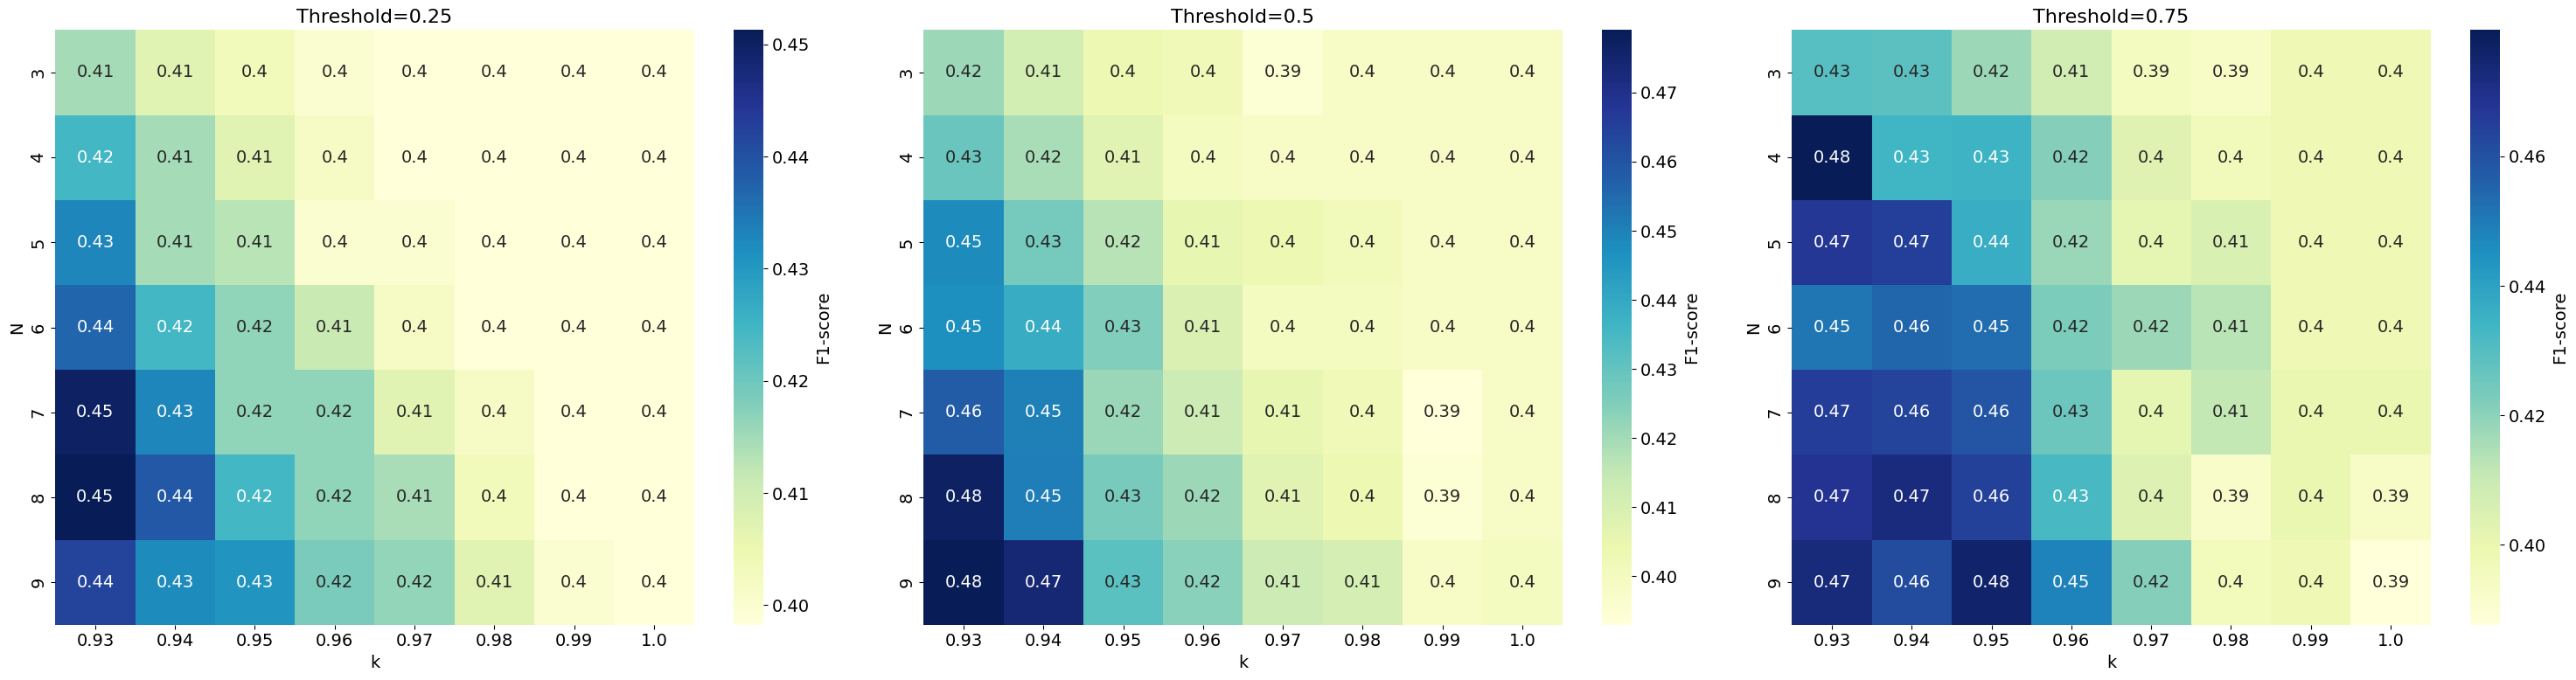

In [29]:
plt.rcParams['font.size'] = 14

n = len(parameter_study_matrix)

plt.figure(figsize=(n*10, 8))

for idx, (th, nested_data) in enumerate(parameter_study_matrix.items(), start=1):
    df = pd.DataFrame(nested_data).T

    plt.subplot(1, n, idx)
    sns.heatmap(df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'F1-score'})

    plt.title(f"Threshold={th}", fontsize=16)
    plt.xlabel('k', fontsize=14)
    plt.ylabel('N', fontsize=14)

plt.tight_layout()
plt.show()

## Selección óptima de parámetros de las matrices de estudio

In [30]:
# Best metrics indices

max_global_acc_index = np.argmax(global_acc_scores)
max_global_acc_th_index, max_global_acc_N_index, max_global_acc_k_index = np.unravel_index(
    max_global_acc_index, (num_th_values, num_N_values, num_k_values))

max_global_recall_index = np.argmax(global_recall_scores)
max_global_recall_th_index, max_global_recall_N_index, max_global_recall_k_index = np.unravel_index(
    max_global_recall_index, (num_th_values, num_N_values, num_k_values))

max_global_precision_index = np.argmax(global_precision_scores)
max_global_precision_th_index, max_global_precision_N_index, max_global_precision_k_index = np.unravel_index(
    max_global_precision_index, (num_th_values, num_N_values, num_k_values))

max_global_f1_index = np.argmax(global_f1_scores)
max_global_f1_th_index, max_global_f1_N_index, max_global_f1_k_index = np.unravel_index(
    max_global_f1_index, (num_th_values, num_N_values, num_k_values))

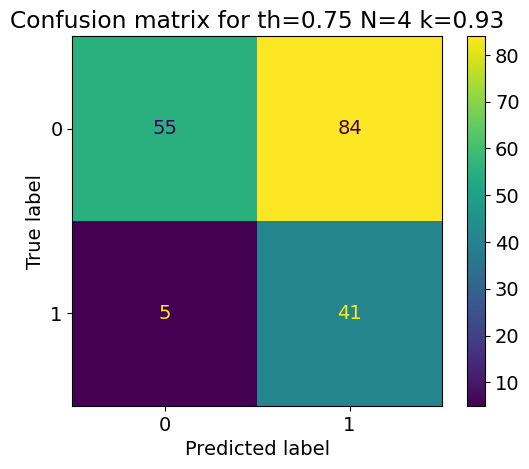

              precision    recall  f1-score   support

           0       0.92      0.40      0.55       139
           1       0.33      0.89      0.48        46

    accuracy                           0.52       185
   macro avg       0.62      0.64      0.52       185
weighted avg       0.77      0.52      0.53       185



In [31]:
th = th_values[max_global_f1_th_index]
N = N_values[max_global_f1_N_index]
k = k_values[max_global_f1_k_index]

filename = f"predictions_N={N}_k={k}_th={th}.csv"
poly_pred_path = paths.data_processed_dir("poly_predictions", filename)
poly_pred = pd.read_csv(poly_pred_path, index_col="ID")

sel_y_true = poly_true_values_df[mask]["label"]
sel_y_pred = poly_pred[mask]["prediction"]

cm = confusion_matrix(sel_y_true, sel_y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f"Confusion matrix for th={th} N={N} k={k}")
plt.show()
print(classification_report(sel_y_true, sel_y_pred))

In [16]:
poly_true_values_df.loc[mask][["change_type", "label"]].value_counts()

change_type  label
stable       0        76
logging      1        25
Name: count, dtype: int64

In [17]:
poly_true_values_df.loc[mask][["change_type", "label"]].value_counts(normalize=True)

change_type  label
stable       0        0.752475
logging      1        0.247525
Name: proportion, dtype: float64

In [18]:
poly_pred.loc[mask].value_counts(normalize=False)

prediction
1.0           54
0.0           47
Name: count, dtype: int64

In [19]:
poly_pred.loc[mask].value_counts(normalize=True)

prediction
1.0           0.534653
0.0           0.465347
Name: proportion, dtype: float64

# Grilla de desempeño y parámetros óptimos

In [20]:
f1_scores = np.zeros((num_th_values, num_N_values, num_k_values))
recall_scores = np.zeros((num_th_values, num_N_values, num_k_values))
precision_scores = np.zeros(
    (num_th_values, num_N_values, num_k_values))
acc_scores = np.zeros((num_th_values, num_N_values, num_k_values))

veg_types = ["native"]
stable_types = ["stable", "drought"]
change_types = ["logging", "fire"]

Classification report for native stable logging
Parameters th=0.75 N=9 k=0.95




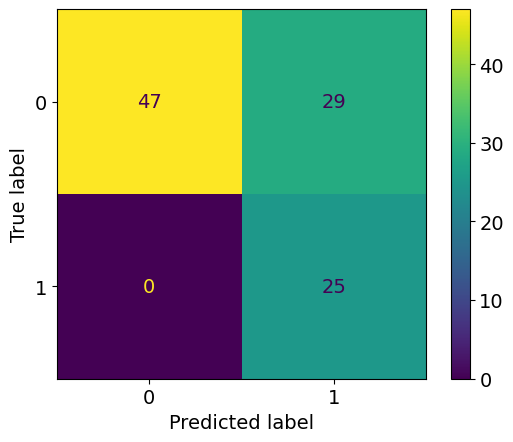



              precision    recall  f1-score   support

           0       1.00      0.62      0.76        76
           1       0.46      1.00      0.63        25

    accuracy                           0.71       101
   macro avg       0.73      0.81      0.70       101
weighted avg       0.87      0.71      0.73       101



Classification report for native stable fire
Parameters th=0.75 N=9 k=0.95




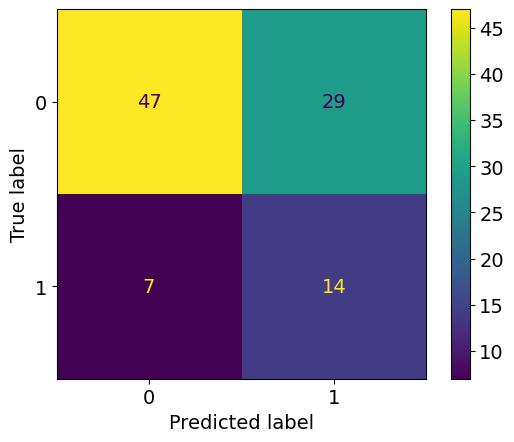



              precision    recall  f1-score   support

           0       0.87      0.62      0.72        76
           1       0.33      0.67      0.44        21

    accuracy                           0.63        97
   macro avg       0.60      0.64      0.58        97
weighted avg       0.75      0.63      0.66        97



Classification report for native drought logging
Parameters th=0.75 N=9 k=0.95




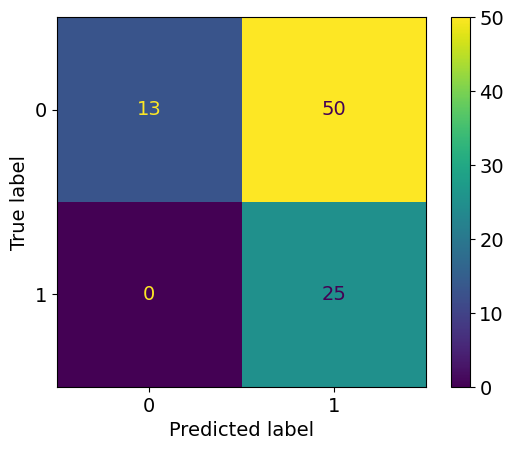



              precision    recall  f1-score   support

           0       1.00      0.21      0.34        63
           1       0.33      1.00      0.50        25

    accuracy                           0.43        88
   macro avg       0.67      0.60      0.42        88
weighted avg       0.81      0.43      0.39        88



Classification report for native drought fire
Parameters th=0.75 N=9 k=0.95




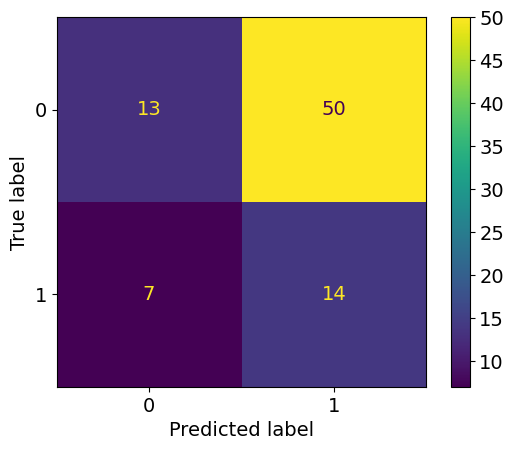



              precision    recall  f1-score   support

           0       0.65      0.21      0.31        63
           1       0.22      0.67      0.33        21

    accuracy                           0.32        84
   macro avg       0.43      0.44      0.32        84
weighted avg       0.54      0.32      0.32        84





In [25]:
metrics_list = []

for veg_type, stable_type, change_type in product(veg_types, stable_types, change_types):

    print(f"Classification report for {veg_type} {stable_type} {change_type}")
    print(f"Parameters th={th} N={N} k={k}")

    veg_type_mask = (poly_true_values_df["vegetation_type"] == veg_type)
    stable_type_mask = (poly_true_values_df["change_type"] == stable_type)
    change_type_mask = (poly_true_values_df["change_type"] == change_type)

    mask = veg_type_mask & (change_type_mask | stable_type_mask)

    th = th_values[max_global_f1_th_index]
    N = N_values[max_global_f1_N_index]
    k = k_values[max_global_f1_k_index]

    filename = f"predictions_N={N}_k={k}_th={th}.csv"
    poly_pred_path = paths.data_processed_dir("poly_predictions", filename)
    
    poly_pred = pd.read_csv(poly_pred_path, index_col="ID")

    sel_y_true = poly_true_values_df[mask]["label"]
    sel_y_pred = poly_pred[mask]["prediction"]

    cm = confusion_matrix(sel_y_true, sel_y_pred)

    print("\n")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    
    print("\n")
    print(classification_report(sel_y_true, sel_y_pred, zero_division=0))

    metrics = {
        'Vegetation Type': veg_type,
        'Non-Change Type': stable_type,
        'Change Type': change_type,
        'Accuracy': accuracy_score(sel_y_true, sel_y_pred),
        'F1-Score': f1_score(sel_y_true, sel_y_pred),
        'Recall': recall_score(sel_y_true, sel_y_pred),
        'Precision': precision_score(sel_y_true, sel_y_pred),
    }

    metrics_list.append(metrics)

    print("\n" + "="*100 + "\n")

In [22]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df

,Vegetation Type,Non-Change Type,Change Type,Accuracy,F1-Score,Recall,Precision
0,native,stable,logging,0.712871,0.632911,1.000000,0.462963
1,native,stable,fire,0.628866,0.437500,0.666667,0.325581
2,native,drought,logging,0.431818,0.500000,1.000000,0.333333
3,native,drought,fire,0.321429,0.329412,0.666667,0.218750
